Data needs to be generated first with [the NEF n-back model](https://github.com/ctn-archive/gosmann-cogsci2015) for the different conditions by editing the `models/nback3.py` file in the repository to generate the following conditions:

* Original data: no edits, store data in `data/nback3-matching`.
* No spaopt: Replace
```python
import nengo.spaopt as spa
from nengo.spaopt import CircularConvolution
```
with
```python
from nengo import spa
from nengo.networks import CircularConvolution
```
and store data in `data/no-spaopt`.
* No spaopt, 16sd: Same replacement as in the previous item and in addition change `default=[1]` in line 23 (subdimensions argument) to `default=[16]`. Store the data in `data/no-spaopt-16sd`.
* Spaopt, 16sd: Change `default=[1]` in line 23 (subdimensions argument) to `default=[16]`. Store the data in `data/spaopt-16sd`.

In [10]:
import os.path
import warnings

import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [11]:
sns.set('paper', 'ticks')

labelpad = 1

rcParams['mathtext.fontset'] = 'stixsans'

single_col_size = (3.35, 3.35 * 0.618)
double_col_size = (7.08, 7.08 * 0.618)
four_by_two_size = (7.08, 8.75)

In [12]:
class InputData(object):
    def __init__(self, n, filename):
        self.n = n
        with open(filename) as f:
            self.stimuli = f.readline().strip()
            self.trials = f.readline().strip()[n:]
            
    def get_lure_type(self, index):
        valid_lures = {
            1: [+1, +2],
            2: [+1, -1],
            3: [-1, -2],
        }[self.n]
    
        for lure_type in valid_lures:
            if self.stimuli[index + self.n] == self.stimuli[index - lure_type]:
                return lure_type
        raise AssertionError("no valid lure found")
        
    @property
    def n_trials(self):
        return 45 + self.n
            
    @property
    def match_trials(self):
        return np.array([c == 'm' for c in self.trials])
    
    @property
    def lure_trials(self):
        return np.array([c == 'l' for c in self.trials])
    
    @property
    def lure_indices(self):
        return np.where(self.lure_trials)[0]
    
    @property
    def lure_types(self):
        return [self.get_lure_type(i) for i in self.lure_indices]
    

class OutputData(object):
    trial_duration = 2.5
    
    def __init__(self, filename):
        with np.load(filename) as data:
            self.trange = data['trange']
            self.comp_out = data['comp_out']
            self.response = data['response']
            
    @property
    def max_t(self):
        return self.trange[-1]
    
    @property
    def dt(self):
        return self.trange[1] - self.trange[0]
    
    
class ExperimentData(object):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data
        
    @property
    def experiment_duration(self):
        return self.output_data.trial_duration * self.input_data.n_trials
    
    def split_trials(self, data):
        size = int(self.experiment_duration / self.output_data.dt)
        return np.asarray(np.split(data[:size], self.input_data.n_trials))
    
    def responses(self):
        split = self.split_trials(self.output_data.response)[self.input_data.n:, :, 0]
        split2 = self.split_trials(self.output_data.comp_out)[self.input_data.n:, :, 0]
        indices = np.tile(np.arange(split.shape[1]), (split.shape[0], 1))
        indices[np.abs(split) < 0.4] = 0
        decision_indices = np.max(indices, axis=1)

        decisions = np.sign(split[np.arange(split.shape[0]), decision_indices])
        decisions[np.logical_or(decision_indices <= 500, decision_indices >= 2499)] = 0
        return decisions
    
    def reaction_times(self):
        split = self.split_trials(self.output_data.response)[self.input_data.n:, :, 0]
        indices = np.tile(np.arange(split.shape[1]), (split.shape[0], 1))
        indices[np.abs(split) < 0.4] = 0
        decision_indices = np.max(indices, axis=1)
        rt = np.max(indices, axis=1) * self.output_data.dt
        rt[np.logical_or(decision_indices <= 500, decision_indices >= 2499)] = np.nan
        return rt
    
    def summary_stats(self):
        match_trials = self.input_data.match_trials
        num_matches = np.sum(match_trials)
        num_mismatches = len(match_trials) - num_matches
        
        responses = self.responses()
        correct_matches = np.sum(responses[match_trials] == 1, axis=0)
        correct_mismatches = np.sum(responses[np.logical_not(match_trials)] == -1, axis=0)
        
        rt = self.reaction_times()
        rt_match = np.nanmean(rt[match_trials], axis=0)
        rt_mismatch = np.nanmean(rt[np.logical_not(match_trials)], axis=0)
    
        df = pd.DataFrame(
            {'cm': [correct_matches], 'c-': correct_mismatches, '#m': num_matches, '#-': num_mismatches,
             'rtm': rt_match, 'rt-': rt_mismatch, 'na': self.percent_no_response()})
        
        for lure_type in set(self.input_data.lure_types):
            selection = np.asarray(self.input_data.lure_types) == lure_type
            num = np.sum(selection)
            correct = np.sum(responses[self.input_data.lure_indices[selection]] == -1, axis=0)
            df['#l{}'.format(lure_type)] = num
            df['cl{}'.format(lure_type)] = correct
        
        return df
    
    def percent_no_response(self):
        rt = self.reaction_times()
        return float(np.sum(np.isnan(rt))) / len(rt)
    
class ConditionData(object):
    def __init__(self, n, basepath):
        self.n = n
        self.basepath = basepath
        self.input_dir = os.path.join(basepath, '{}back'.format(n))
        self.output_dir = os.path.join(basepath, 'out_{}back'.format(n))
        self.experiments = []
        
        for filename in os.listdir(self.input_dir):
            seed, ext = os.path.splitext(filename)
            
            # FIXME missing some data for these trials because of crashed simulations
            if seed == '11' or seed == '29':
                continue
            
            if ext == '.txt':
                self.add_seed_data(seed)
                
    def add_seed_data(self, seed):
        try:
            input_data = InputData(self.n, os.path.join(self.input_dir, str(seed) + '.txt'))
            output_data = OutputData(os.path.join(self.output_dir, str(seed) + '.npz'))
            self.experiments.append(ExperimentData(input_data, output_data))
        except:
            warnings.warn("Could not load data for seed {} (n={}, basepath={}).".format(seed, self.n, self.basepath))

    def mean_stats(self):
        return reduce(lambda x, y: x + y, (e.summary_stats() for e in self.experiments)) / len(self.experiments)
    
    def df(self):
        return pd.concat([e.summary_stats() for e in self.experiments])
    
    def reaction_times(self):
        return pd.concat([pd.DataFrame({
            'rt': e.reaction_times(),
            'm': e.input_data.match_trials,
            'trial': range(45)}) for e in self.experiments])

In [13]:
def to_df(data, condition):
    dfs = []
    for d in data:
        df = d.df()
        df['n'] = d.n
        dfs.append(df)

    df = pd.concat(dfs)

    df['%m'] = (df['cm'] / df['#m'])
    df['%-'] = (df['c-'] / df['#-'])
    df['%'] = (df['cm'] + df['c-']) / (df['#m'] + df['#-'])
    
    df['Condition'] = condition
    
    return df

In [14]:
df = pd.concat([
    to_df([ConditionData(n, 'data/nback3-matching/') for n in [1, 2, 3]], 'optimized, sd=1'),
    to_df([ConditionData(n, 'data/no-spaopt/') for n in [1, 2, 3]], 'default, sd=1'),
    to_df([ConditionData(n, 'data/no-spaopt-16sd/') for n in [1, 2, 3]], 'default, sd=16'),
    to_df([ConditionData(n, 'data/spaopt-16sd/') for n in [1, 2, 3]], 'optimized, sd=16')
])

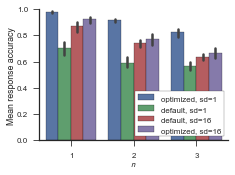

In [23]:
plt.figure(figsize=(single_col_size[0], single_col_size[1] * 1.25))
sns.barplot('n', '%', hue='Condition', data=df)
plt.xlabel('$n$', labelpad=labelpad)
plt.ylabel('Mean response accuracy', labelpad=labelpad)
plt.legend(loc='lower right', frameon=True)
sns.despine()
plt.tight_layout()